# <center> Image Sentiment Classification <center>

## Importing important libraries and setting up dependencies

In [1]:
import tensorflow as tf
import os

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
# Avoiding OOM error by limiting vram use by model
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Removing Noisy Images

In [5]:
import cv2
import imghdr

In [6]:
data_dir = 'data'

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [12]:
# We are going to use os to go through our data
#os.listdir(os.path.join(data_dir, 'Happy'))

In [15]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list data\Happy\427394C200000578-0-image-a-24_1500384481554.jpg
Image not in ext list data\Happy\Happy_People_A_Year_in_the_Taiga_poster (1).jpg
Image not in ext list data\Happy\where-to-watch-shiny-happy-people.webp
Image not in ext list data\Sad\1cd95b44e0d785987a6596d4baf940fc19-13-sad-white-man.2x.h473.w710.jpg
Image not in ext list data\Sad\african-american-depressive-sad-broken-260nw-475790911.jpg
Image not in ext list data\Sad\depositphotos_210655610-stock-photo-sad-man-sitting-floor-home.jpg
Image not in ext list data\Sad\depositphotos_4584891-stock-photo-sad-man-in-a-empty.jpg
Image not in ext list data\Sad\sad-person-pictures-2560-x-1707-a8ginomrbkhyh3ri.jpg
Image not in ext list data\Sad\sad-person-pictures-2bnso9uiwlhrikrx.jpg
Image not in ext list data\Sad\very-sad-man-sitting-alone-on-white-background-depressed-young-man-sitting-businessman-vector.jpg


## Load Data

In [17]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 164 files belonging to 2 classes.


In [20]:
data_iterator = data.as_numpy_iterator()

In [28]:
# Images represented as numpy arrays
batch = data_iterator.next()

In [29]:
batch[1]

array([0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

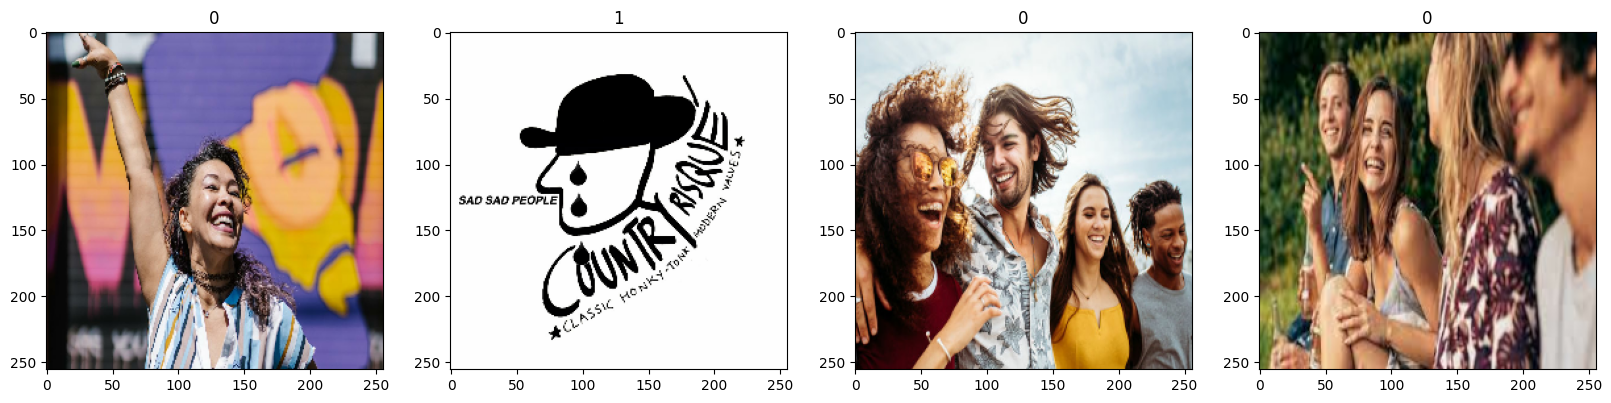

In [30]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## Preprocessing/Scaling

In [31]:
# we scale the image values between 0 and 1 instead of o-255 because it helps our deep learning model genralize faster and produce better results
data = data.map(lambda x,y: (x/255, y))